<a href="https://colab.research.google.com/github/mohsina680/BuildablesDataScienceFellowship/blob/main/Task13_DS_FellowShip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Task13_DS_FellowShip(Model Evaluation)**

In [21]:
# Imports + Load Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, roc_auc_score, classification_report, ConfusionMatrixDisplay
)

RANDOM_STATE = 42

df = pd.read_csv("/content/train.csv")
print("Shape:", df.shape)
df.head()


Shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [22]:
# Cell 2: Preprocessing & Split
target = "Survived"
features = ['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']

X = df[features]
y = df[target]

numeric_features = ['Age','Fare','SibSp','Parch','Pclass']
categorical_features = ['Sex','Embarked']

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)


Train shape: (712, 7)  Test shape: (179, 7)


In [23]:
# Logistic Regression with Cross-Validation
pipe_lr = Pipeline([
    ("prep", preprocessor),
    ("model", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])

# single split
pipe_lr.fit(X_train, y_train)
acc_single = accuracy_score(y_test, pipe_lr.predict(X_test))

# cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_scores = cross_val_score(pipe_lr, X, y, cv=cv, scoring="accuracy")

print("Single split accuracy:", acc_single)
print("CV mean accuracy:", cv_scores.mean())
print("\nInsight: Cross-validation gives a more reliable performance estimate than a single split.")


Single split accuracy: 0.8044692737430168
CV mean accuracy: 0.7935157868307073

Insight: Cross-validation gives a more reliable performance estimate than a single split.


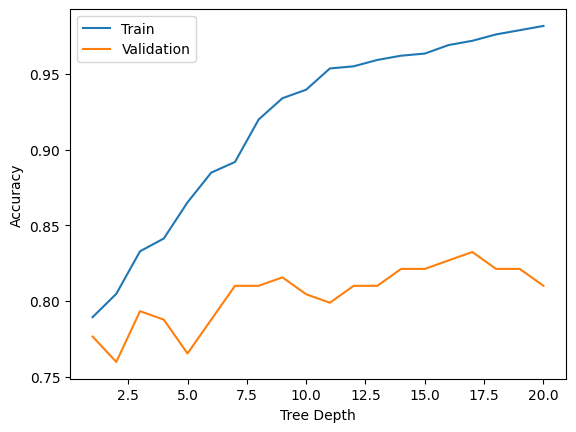

Insight: Shallow trees underfit, very deep trees overfit; best depth is where val accuracy peaks.


In [24]:
#Decision Tree Overfitting/Underfitting
train_acc, val_acc, depths = [], [], range(1,21)

for d in depths:
    tree = Pipeline([
        ("prep", preprocessor),
        ("model", DecisionTreeClassifier(max_depth=d, random_state=RANDOM_STATE))
    ])
    tree.fit(X_train, y_train)
    train_acc.append(accuracy_score(y_train, tree.predict(X_train)))
    val_acc.append(accuracy_score(y_test, tree.predict(X_test)))

plt.plot(depths, train_acc, label="Train")
plt.plot(depths, val_acc, label="Validation")
plt.xlabel("Tree Depth"); plt.ylabel("Accuracy"); plt.legend(); plt.show()

print("Insight: Shallow trees underfit, very deep trees overfit; best depth is where val accuracy peaks.")


In [25]:
#Logistic Regression Precision/Recall/F1
y_pred = pipe_lr.predict(X_test)
print(classification_report(y_test, y_pred))
print("Insight: Precision, recall, and F1-score give more detail than accuracy, useful with imbalanced classes.")


              precision    recall  f1-score   support

           0       0.81      0.89      0.85       110
           1       0.79      0.67      0.72        69

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179

Insight: Precision, recall, and F1-score give more detail than accuracy, useful with imbalanced classes.


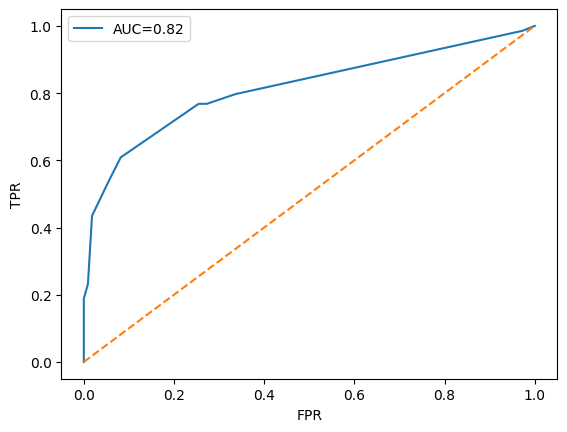

Insight: AUC measures how well the model separates survivors vs non-survivors beyond accuracy.


In [26]:
#Decision Tree ROC & AUC
tree = Pipeline([
    ("prep", preprocessor),
    ("model", DecisionTreeClassifier(max_depth=4, random_state=RANDOM_STATE))
])
tree.fit(X_train, y_train)

y_prob = tree.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

plt.plot(fpr, tpr, label=f"AUC={auc:.2f}")
plt.plot([0,1],[0,1],'--'); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.show()
print("Insight: AUC measures how well the model separates survivors vs non-survivors beyond accuracy.")


In [27]:
#Compare LR vs Decision Tree (with/without CV)
models = {
    "LogReg": LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    "Tree": DecisionTreeClassifier(max_depth=4, random_state=RANDOM_STATE)
}

for name, model in models.items():
    pipe = Pipeline([("prep", preprocessor), ("model", model)])
    pipe.fit(X_train, y_train)
    acc = accuracy_score(y_test, pipe.predict(X_test))
    cv_acc = cross_val_score(pipe, X, y, cv=5, scoring="accuracy").mean()
    print(f"{name}: Single={acc:.3f}, CV={cv_acc:.3f}")

print("\nInsight: Cross-validation reduces variance and gives a more stable performance estimate.")


LogReg: Single=0.804, CV=0.788
Tree: Single=0.788, CV=0.805

Insight: Cross-validation reduces variance and gives a more stable performance estimate.


In [28]:
# Random Forest with Cross-Validation
rf = Pipeline([
    ("prep", preprocessor),
    ("model", RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE))
])
cv_scores = cross_val_score(rf, X, y, cv=5, scoring="accuracy")
print("RF CV mean accuracy:", cv_scores.mean())
print("Insight: Random Forest improves stability and reduces variance compared to a single tree.")


RF CV mean accuracy: 0.8069989328981231
Insight: Random Forest improves stability and reduces variance compared to a single tree.


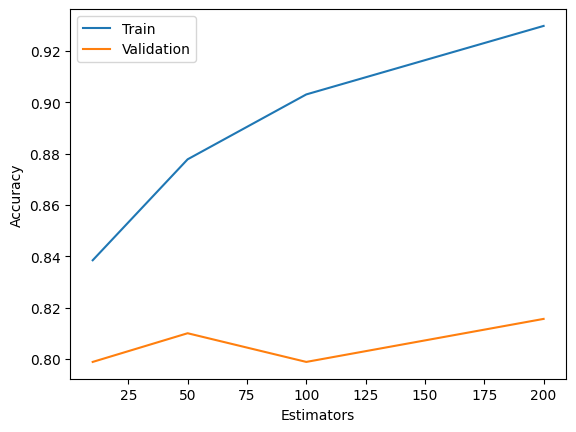

Insight: Too many estimators can overfit; optimal value balances train and validation accuracy.


In [29]:
#Gradient Boosting Overfitting/Underfitting
train_acc, val_acc, ests = [], [], [10,50,100,200]

for n in ests:
    gb = Pipeline([
        ("prep", preprocessor),
        ("model", GradientBoostingClassifier(n_estimators=n, learning_rate=0.1, random_state=RANDOM_STATE))
    ])
    gb.fit(X_train, y_train)
    train_acc.append(accuracy_score(y_train, gb.predict(X_train)))
    val_acc.append(accuracy_score(y_test, gb.predict(X_test)))

plt.plot(ests, train_acc, label="Train")
plt.plot(ests, val_acc, label="Validation")
plt.xlabel("Estimators"); plt.ylabel("Accuracy"); plt.legend(); plt.show()
print("Insight: Too many estimators can overfit; optimal value balances train and validation accuracy.")


In [30]:
#Random Forest Precision/Recall/F1
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))
print("Insight: Precision, recall, and F1 highlight trade-offs beyond accuracy in ensemble models.")


              precision    recall  f1-score   support

           0       0.82      0.89      0.86       110
           1       0.80      0.70      0.74        69

    accuracy                           0.82       179
   macro avg       0.81      0.79      0.80       179
weighted avg       0.81      0.82      0.81       179

Insight: Precision, recall, and F1 highlight trade-offs beyond accuracy in ensemble models.


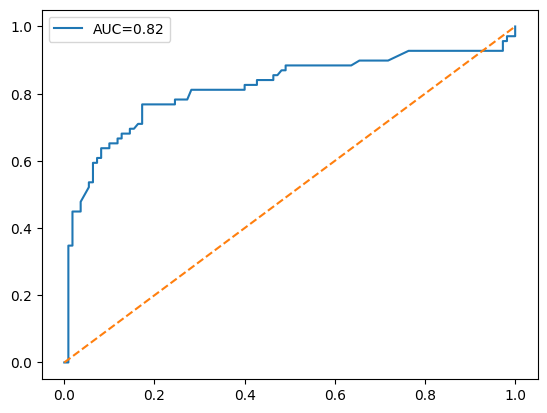

Insight: Boosting models can achieve strong separation power, measured by ROC-AUC.


In [31]:
#gradient Boosting ROC & AUC
gb = Pipeline([
    ("prep", preprocessor),
    ("model", GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=RANDOM_STATE))
])
gb.fit(X_train, y_train)
y_prob = gb.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_prob)
fpr,tpr,_=roc_curve(y_test,y_prob)
plt.plot(fpr,tpr,label=f"AUC={auc:.2f}")
plt.plot([0,1],[0,1],'--'); plt.legend(); plt.show()
print("Insight: Boosting models can achieve strong separation power, measured by ROC-AUC.")


In [32]:
#Compare SVM, RF, GB (All Metrics)
models = {
    "SVM": SVC(probability=True, random_state=RANDOM_STATE),
    "RF": RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE),
    "GB": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=RANDOM_STATE)
}

results = []
for name, model in models.items():
    pipe = Pipeline([("prep", preprocessor), ("model", model)])
    scores = cross_validate(pipe, X, y, cv=5,
                            scoring=["accuracy","precision","recall","f1","roc_auc"])
    results.append({
        "Model": name,
        "Acc": scores["test_accuracy"].mean(),
        "Prec": scores["test_precision"].mean(),
        "Rec": scores["test_recall"].mean(),
        "F1": scores["test_f1"].mean(),
        "AUC": scores["test_roc_auc"].mean()
    })

pd.DataFrame(results)
print("Insight: Comparing multiple metrics helps choose the best overall model, not just the highest accuracy.")


Insight: Comparing multiple metrics helps choose the best overall model, not just the highest accuracy.
